In [1]:
# data arrays/frames
import cudf, numpy as np, pandas as pd
import cuml, sklearn

# algos, datasets
import xgboost; from xgboost import plot_tree
from sklearn import datasets; from sklearn.metrics import confusion_matrix, accuracy_score

In [2]:
# measurement
import time
# plotting
import matplotlib.pylab as plt

In [3]:
import rapids_lib as rl
''' NOTE: anytime changes are made to rapids_lib.py you can either:
    1. refresh/reload via the code below, OR
    2. restart the kernel '''    
import importlib; importlib.reload(rl)

<module 'rapids_lib' from '/rapids/notebooks/ml_tutorial/rapids_lib.py'>

How big dataset?

In [4]:
NSAMPLES = 20000000
NCLASSES = 5
DATA_FORMAT = 'parquet'
GRAPHICS_MODE = '2D'

In [5]:
rl.accept_choices ( NSAMPLES, DATA_FORMAT, GRAPHICS_MODE )

Below are your current choices for the key parameters in the notebook, return to the cell above to revise them. 

                Number of Total Samples:  20000000
         Data Format [ CSV or parquet ]:  parquet
              GraphicsMode [ 2D or 3D ]:  2D


MAKE DATASET

In [6]:
expLog = {}

In [7]:
data, labels, t_gen = rl.generate_galaxy_dataset (nSamples = NSAMPLES, nLabels = NCLASSES, rSeed = 1)

expLog = rl.update_log( expLog, [ ['generate_galaxy', t_gen] ] );

rl.visualize_data( data, labels)

generating shuffled samples n = 20000000
 + adding log entry [ generate_galaxy          :   1.33170 s ]


plotting  50000 out of 50000  [ stride =  400 ]


In [8]:
##data loading


def query_latest_parquet_filename( destinationDirectory ):
    outputFilenames = !cd $destinationDirectory && ls -t
    latestFilename = destinationDirectory + '/' + outputFilenames[0]
    return latestFilename

def query_size_on_disk ( filename ):
    duOutput = !du -hs $filename
    fileSize = duOutput[0].split('\t')[0]
    return fileSize

def write_data_to_lts ( data, labels, mode = 'parquet', destinationDirectory = 'lts_data', fileTag = 'train', shardID = 0  ):        
    
    startTime = time.time()
    print('saving as', mode)
    if mode == 'parquet': 
        data.to_parquet( path = destinationDirectory, compression = 'snappy')
        filenameX = query_latest_parquet_filename(destinationDirectory)
        
        labels.to_parquet( path = destinationDirectory, compression = 'snappy')
        filenameY = query_latest_parquet_filename(destinationDirectory)
        
    elif mode == 'csv':
        filenameX = 'data_' + fileTag + '.csv'
        filenameY = 'labels_' + fileTag + '.csv'
        labels.to_csv( path = filenameX )
        data.to_csv( path = filenameY )
    
    elapsedTime = time.time() - startTime
        
    print( '   wrote {} DATA into {} '.format( query_size_on_disk(filenameX), filenameX) )
    print( '   wrote {} LABELS into {}'.format( query_size_on_disk(filenameY), filenameY ) )        
    
    return filenameX, filenameY, elapsedTime

def read_data_from_lts ( filenameData, filenameLabels, mode = 'parquet', device='GPU' ):    
    
    startTime = time.time()
    print('GPU/cudf reading from', mode)
    
    if mode == 'parquet':        
        if device == 'GPU': data_reader_function = cudf.read_parquet
        else: data_reader_function = pd.read_parquet
    elif mode == 'csv':
        if device == 'GPU': data_reader_function = cudf.read_csv
        else: data_reader_function = pd.read_csv

    data = data_reader_function( filenameData )
    labels = data_reader_function( filenameLabels )
    
    return data, labels, time.time() - startTime

In [9]:
#data reading 

# write to disk & load from disk
filenameX, filenameY, t_wLTS = write_data_to_lts ( data, labels, mode = DATA_FORMAT)
""
dataLTS, labelsLTS, t_rLTS = read_data_from_lts ( filenameX, filenameY, mode = DATA_FORMAT, device = 'GPU')
dataLTS_pDF, labelsLTS_pDF, t_rLTS_CPU = read_data_from_lts ( filenameX, filenameY, mode = DATA_FORMAT, device = 'CPU')

expLog = rl.update_log( expLog, [['write_data_to_lts_' + DATA_FORMAT, t_wLTS], 
                                 ['read_data_from_lts_' + DATA_FORMAT, t_rLTS],
                                 ['CPU_read_data_from_lts_' + DATA_FORMAT, t_rLTS_CPU]] );   


saving as parquet
   wrote 459M DATA into lts_data/7383f6d653e547e49d9be212faea7f98.parquet 
   wrote 7.2M LABELS into lts_data/e7d44be9f22541228b0d8113dbb92786.parquet
GPU/cudf reading from parquet
GPU/cudf reading from parquet
 + adding log entry [ write_data_to_lts_parquet:   1.97983 s ]
 + adding log entry [ read_data_from_lts_parquet:   0.36230 s ]
 + adding log entry [ CPU_read_data_from_lts_parquet:   0.56714 s ]


In [10]:
# drop the original dataframes and retain the copy read from LTS, to minimize redundancy
del( data, labels); data = dataLTS; labels = labelsLTS; import gc; gc.collect();

###  1. Train / Test split 

In [11]:
def split_train_test ( dataDF, labelsDF, trainRatio = .75 ):
    print('splitting data into training and test set')
    sT = time.time()
    
    splitIndex = int( dataDF.shape[0] * trainRatio )
    assert ( splitIndex > 1 and splitIndex < dataDF.shape[0] )
    assert ( dataDF.shape[0] == labelsDF.shape[0] )
    
    trainDF = dataDF.iloc[0:splitIndex]
    testDF = dataDF.iloc[splitIndex:]
    trainLabelsDF = labelsDF.iloc[0:splitIndex]
    testLablesDF = labelsDF.iloc[splitIndex:]
    
    return trainDF, trainLabelsDF, testDF, testLablesDF, time.time() - sT

In [12]:
def scale_dataframe_inplace ( targetDF, trainMeans = {}, trainSTDevs = {} ):    
    print('rescaling data')
    sT = time.time()
    for iCol in targetDF.columns:
        
        # omit scaling label column
        if iCol == targetDF.columns[-1] == 'label': continue
            
        # compute means and standard deviations for each column [ should skip for test data ]
        if iCol not in trainMeans.keys() and iCol not in trainSTDevs.keys():            
            trainMeans[iCol] = targetDF[iCol].mean()
            trainSTDevs[iCol] = targetDF[iCol].std()
            
        # apply scaling to each column
        targetDF[iCol] = ( targetDF[iCol] - trainMeans[iCol] ) / ( trainSTDevs[iCol] + 1e-10 )
        
    return trainMeans, trainSTDevs, time.time() - sT

In [13]:
# split
trainData_cDF, trainLabels_cDF, testData_cDF, testLabels_cDF, t_split = split_train_test (data, labels)
# apply standard scaling
trainMeans, trainSTDevs, t_scaleTrain = scale_dataframe_inplace ( trainData_cDF )
_,_, t_scaleTest = scale_dataframe_inplace ( testData_cDF, trainMeans, trainSTDevs )    

expLog = rl.update_log( expLog, [['split_train_test', t_split],
                                 ['scale_train_data', t_scaleTrain],
                                 ['scale_test_data', t_scaleTest]] ); 

splitting data into training and test set
rescaling data
rescaling data
 + adding log entry [ split_train_test         :   0.07400 s ]
 + adding log entry [ scale_train_data         :   0.01859 s ]
 + adding log entry [ scale_test_data          :   0.00885 s ]


In [14]:
def train_model (trainData_cDF,trainLabels_cDF, paramsGPU = {}):
    
    print('training xgboost model on GPU');  
    startTime = time.time()    
    trainDMatrix = xgboost.DMatrix( trainData_cDF.to_pandas(), label = trainLabels_cDF.to_pandas())
    trainedModelGPU = xgboost.train( dtrain = trainDMatrix, params = paramsGPU, num_boost_round = paramsGPU['num_boost_rounds'] )    
    return trainedModelGPU, print("Training time in seconds:" + str(time.time() - startTime))

In [15]:
nCores = !nproc --all
nCores = int(nCores[0])

In [16]:
paramsGPU = {
    'max_depth': 6,
    'num_boost_rounds': 10,    
    'objective': 'multi:softmax',
    'num_class': NCLASSES,
    'tree_method': 'gpu_hist',    
    'n_gpus': 1, 
    'random_state': 0
}

In [17]:
def test_model ( trainedModelGPU, testData_cDF, testLabels_cDF ):    
    startTime = time.time()   
    testDMatrix = xgboost.DMatrix( testData_cDF.to_pandas(), label=testLabels_cDF.to_pandas())
    
    predictionsGPU = trainedModelGPU.predict(testDMatrix)    
    return predictionsGPU, print("Inference time in seconds:" + str(time.time() - startTime))

In [18]:
# model training
trainedModelGPU, t_train = train_model ( trainData_cDF, trainLabels_cDF, paramsGPU)

training xgboost model on GPU
Training time in seconds:7.696150064468384


In [19]:
# model inference
predictionsGPU, t_infer = test_model ( trainedModelGPU, testData_cDF, testLabels_cDF)

Inference time in seconds:0.9437041282653809


In [20]:
testLabels_pDF = testLabels_cDF.to_pandas()
accuracyGPU = accuracy_score(testLabels_pDF, predictionsGPU)

print( accuracyGPU )


0.9953026


In [23]:
cMat = confusion_matrix(testLabels_pDF, predictionsGPU)

[[ 916077     246    1059     385     388]
 [      5  976403      28       3       0]
 [   1267      79  977750   10934     884]
 [     79     117    5920 1029141    1959]
 [     15       0     104      15 1077142]]


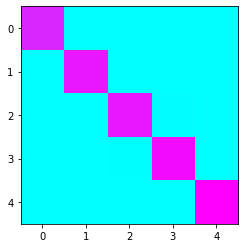

In [24]:
print(cMat)
plt.imshow(cMat, cmap ='cool')

CPU times: user 233 ms, sys: 139 ms, total: 373 ms
Wall time: 875 ms


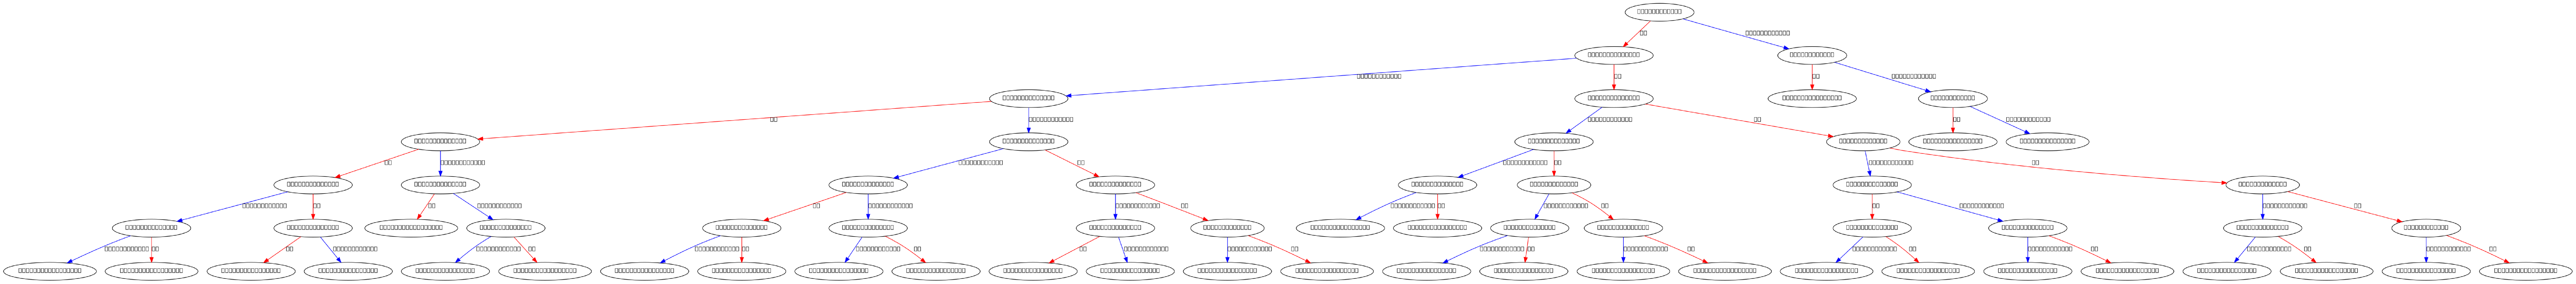

In [25]:
%%time
fig = plt.figure(figsize=(200,100))
plot_tree(trainedModelGPU, num_trees=0, ax=plt.subplot(1,1,1))

In [26]:
%%time
rl.visualize_data(trainData_cDF, trainLabels_cDF, maxSamplesToPlot=100000)

plotting  100000 out of 100000  [ stride =  150 ]
CPU times: user 1.47 s, sys: 36.9 ms, total: 1.51 s
Wall time: 1.5 s


In [27]:
rl.visualize_data( testData_cDF, predictionsGPU )

plotting  50000 out of 50000  [ stride =  100 ]


In [28]:
expLog

{'generate_galaxy': 1.3317036628723145,
 'write_data_to_lts_parquet': 1.9798283576965332,
 'read_data_from_lts_parquet': 0.36229920387268066,
 'CPU_read_data_from_lts_parquet': 0.5671424865722656,
 'split_train_test': 0.07399749755859375,
 'scale_train_data': 0.018593788146972656,
 'scale_test_data': 0.008852243423461914}